## Import libraries


In [417]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
#and whatever you need

## KNN Implementation


In [410]:
import pandas as pd
import numpy as np
from collections import Counter

class KNNClassifier:
    def __init__(self, k):
        self.k = k

    def fit(self, X, y):
        self.data_df = pd.concat([X, y], axis=1)


    def predict(self, X):
        X = np.array(X, dtype=np.float64)

        predictions = []

        for specific_vector in X:
            if specific_vector.shape[0] != self.data_df.shape[1] - 1:
                raise ValueError(f"Specific vector must have {self.data_df.shape[1]-1} features.")
            
            distances = np.linalg.norm(self.data_df.drop(columns=["bad_loans"]).values - specific_vector, axis=1)
            self.data_df['distance'] = distances

            k_nearest_neighbors = self.data_df.nsmallest(self.k, 'distance')
            majority_label = Counter(k_nearest_neighbors['bad_loans']).most_common(1)[0][0]
            
            self.data_df = self.data_df.drop(columns=["distance"])

            predictions.append(majority_label)
        
        return np.array(predictions)

## Load and preprocess

#### TO DO:

###### 1-Load data

###### 2-Sample equal number of samples from each class. find a reasonable number.

###### 3-Encode categorical values

###### 4-Keep these columns and drop the rest : grade, term, home_ownership, emp_length

###### 5-Split data to train, validation and test set

###### 6-Scale the data(normalization)

###### 7-The target column is "bad_loans"


In [411]:
def encode_data(data):
    employment_mapping = {'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
                      '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10}
    data.loc[:, 'emp_length'] = data['emp_length'].str.strip().map(employment_mapping)
    alphabet_mapping = {chr(i + 65): int(i) for i in range(26)}
    data.loc[:, "grade"] = data["grade"].str.strip().map(alphabet_mapping)
    df = pd.get_dummies(data, columns=['term', 'home_ownership'], drop_first=True)
    # Ensure any object columns are inferred to the correct type (if necessary)
    df["emp_length"] = df["emp_length"].astype(float)
    df["grade"] = df["grade"].astype(float)
    bool_columns = df.select_dtypes(include=['bool']).columns
    df[bool_columns] = df[bool_columns].astype(float)
    return df

def load_and_preprocess_data(path):
    df = pd.read_csv(
        path, 
        sep=',', 
        usecols=["grade", "term", "home_ownership", "emp_length", "bad_loans"], 
        dtype={"grade": "object", "term": "object", "home_ownership": "object", "emp_length": "object", "bad_loans": "int64"}
    )
    # print(df.dtypes)
    df_clean = df.dropna()
    df = encode_data(df_clean)

    samples_num = df["bad_loans"].value_counts().min()
    df_minor = df[df["bad_loans"] == 1]  
    df_major = df[df["bad_loans"] == 0] 
    df_major = df_major.sample(n=samples_num, random_state=29*2)
    df_balance = pd.concat([df_major, df_minor])
    df = df_balance.sample(frac=1, random_state=29).reset_index(drop=True)

    first_cut = round(0.8 * df.shape[0])
    second_cut = round(first_cut + 0.1 * df.shape[0])
    return df.loc[:first_cut].drop(columns=["bad_loans"]), df.loc[first_cut:second_cut].drop(columns=["bad_loans"]), df.loc[second_cut:].drop(columns=["bad_loans"]), df.loc[:first_cut, ["bad_loans"]], df.loc[first_cut:second_cut, ["bad_loans"]], df.loc[second_cut:, ["bad_loans"]], df.columns
    # return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, X.columns



#### Training functions


In [412]:
def train_decision_tree(X_train, y_train, d):    
    model = DecisionTreeClassifier(max_depth=d, random_state=29)
    model.fit(X_train, y_train)
    return model

def train_rf(X_train, y_train, param=None):
    if param is None:
        param = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    
    rf = RandomForestClassifier(random_state=29)
    grid_search = GridSearchCV(rf, param, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train.values.ravel())

    best_rf = grid_search.best_estimator_
    return best_rf

def train_knn(X_train, y_train, k):
    model = KNNClassifier(k)
    model.fit(X_train, y_train)
    return model

def train_adaboost(X_train, y_train, n):
    weak_learner = DecisionTreeClassifier(max_depth=1)

    model = AdaBoostClassifier(estimator=weak_learner, n_estimators=n, learning_rate=1.0, random_state=42)
    model.fit(X_train, y_train.values.ravel())
    return model


    

In [413]:
def get_model_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [414]:
def compare_models(dt_accuracy, knn_accuracy, ab_accuracy, rf_accuracy):
    models = ['Decision Tree', 'KNN','Adaboost', 'Random Forest']
    accuracies = [dt_accuracy, knn_accuracy, ab_accuracy,rf_accuracy]

    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies)
    plt.title('Model Comparison - Test Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
    plt.show()

## The main function

#### TO DO:

###### Use the defined functions to load the dataset and train the models.

###### You should optimize the hyperparameters. Maximum depth for DT and k for KNN and n_estimators for Adaboost.

###### Find the best DT, KNN, Adaboost and RF model and report the test accuracy.


Fitting 5 folds for each of 81 candidates, totalling 405 fits


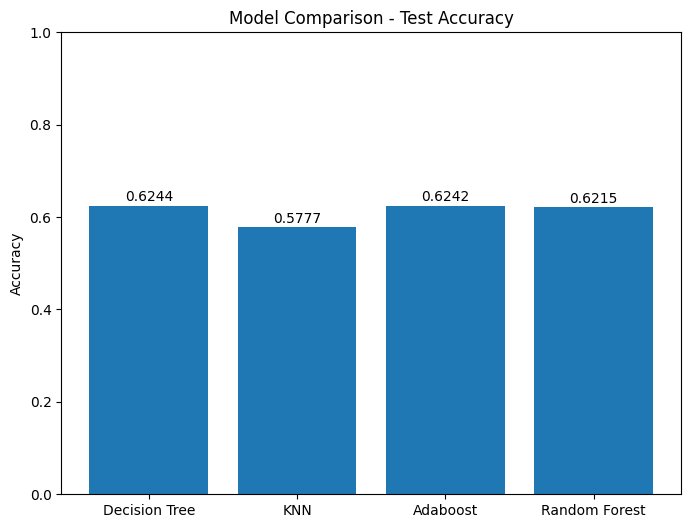

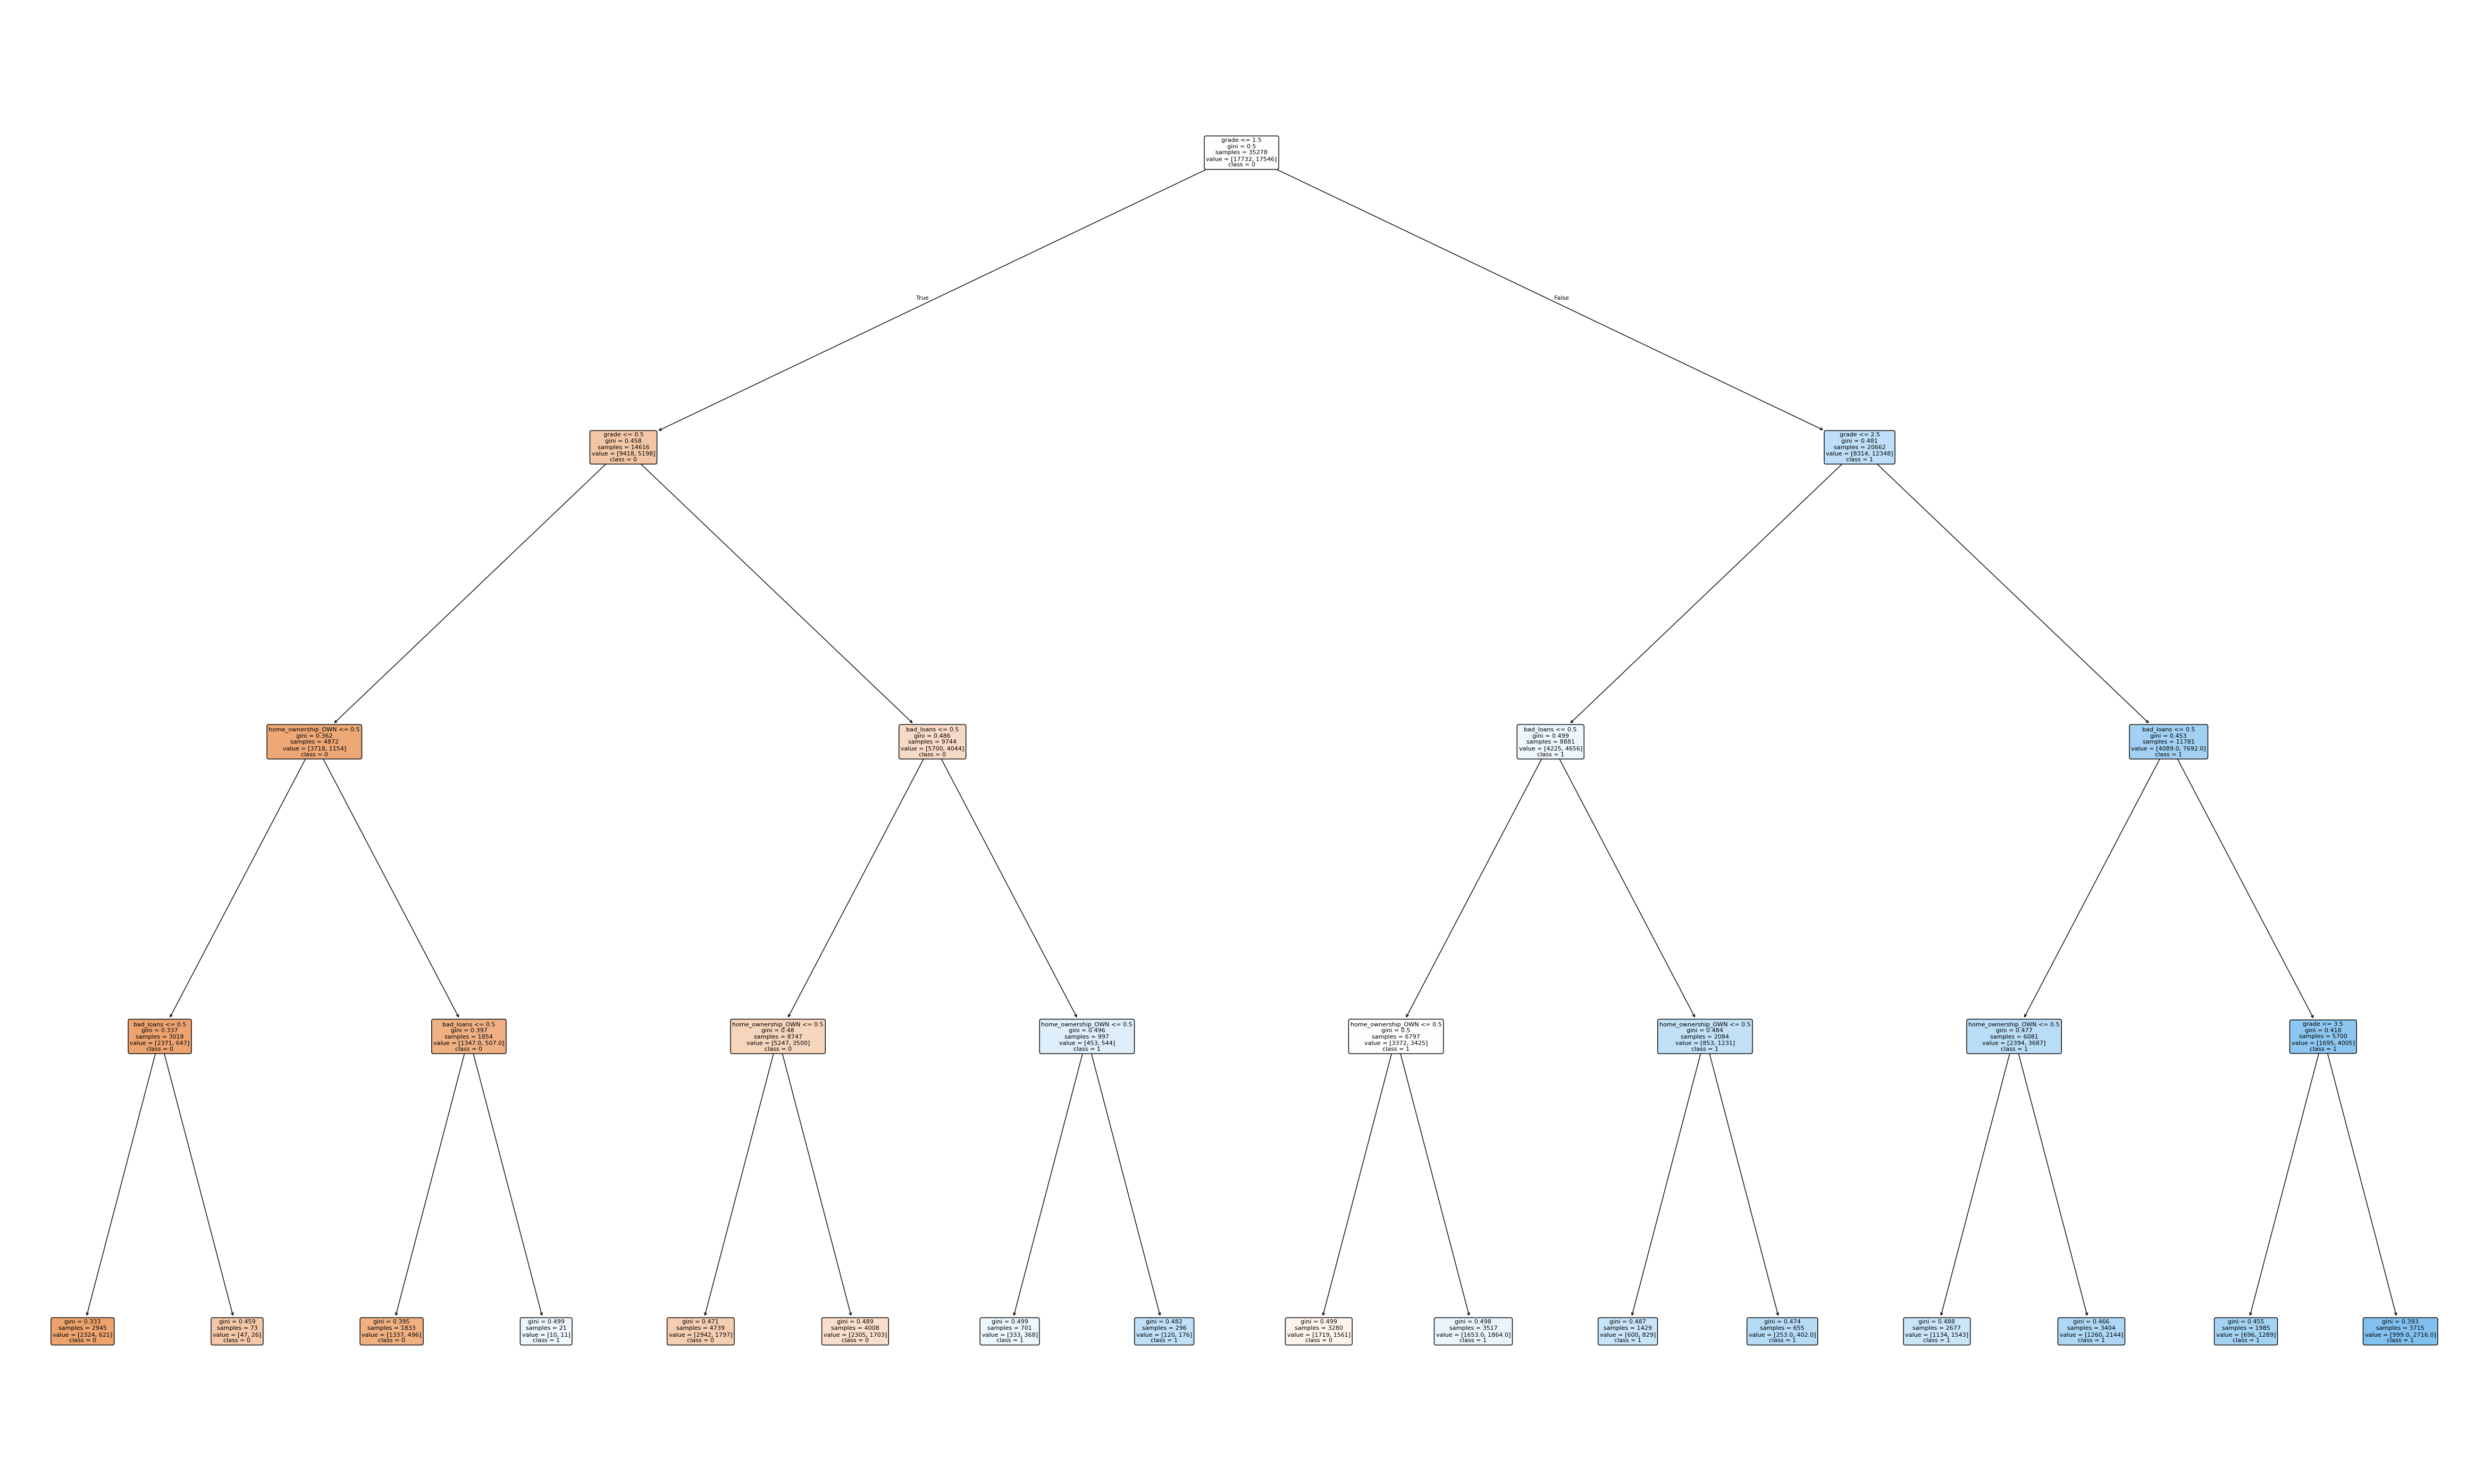

In [ ]:

def main():
    # load data
    X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, X_columns = load_and_preprocess_data("loan_sub.csv")
    # train models
    knn_model = train_knn(X_train_scaled, y_train, 5)
    dt_model = train_decision_tree(X_train_scaled, y_train, 4)
    rf_model = train_rf(X_train_scaled, y_train)
    ada_model = train_adaboost(X_train_scaled, y_train, n=50)
    # calculate accuracy
    knn_test_acc = get_model_accuracy(knn_model, X_test_scaled, y_test)
    dt_test_acc = get_model_accuracy(dt_model, X_test_scaled, y_test)
    rf_test_acc = get_model_accuracy(rf_model, X_test_scaled, y_test)
    ab_test_acc = get_model_accuracy(ada_model, X_test_scaled, y_test)
    #‌ plot accuracy
    compare_models(dt_test_acc, knn_test_acc, ab_test_acc, rf_test_acc)
 
    plt.figure(figsize=(30,18))
    plot_tree(dt_model, 
            feature_names=X_columns, 
            class_names=["0", "1"],       
            filled=True,
            rounded=True,
            fontsize=8
            )
    plt.show()


if __name__ == "__main__":
    main()